# Load Libraries

In [2]:
import tensorflow as tf

import numpy as np
from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

import matplotlib.pyplot as py
import seaborn as sb
  
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from hyperopt import hp, tpe, fmin, Trials
#import neptunecontrib.hpo.utils as hpo_utils
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Avoid OOM errors by setting GPU Memory Consumption Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    pass

# EDA & Preprocessing

## Class

In [4]:
class EDA:
    '''
    this class
       handles with missing values in the dataset (replace it)
       perform some visualization plots on data  
       
    load dataset from path or assign as pandas.DataFrame
    then handle missing values ... before anything
    '''
    
    # split dataframe into categorical & continues to make visualization easy
    # add features after handling missing values
    __categorical, __continues, __date_columns = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    __cont_len, __cate_len = 0, 0
    
    def __init__(self, dataset, num_unique_values, perc_miss, target_index = None):
        '''
        dataset : Path (location) of dataset to which the operations will be applied or pandas.DaFrame
        num_unique_values : Number of unique values in a feature has 'int datatype',
                            to deal with it as categorical feature.
                    
        perc_miss : Percentage of missing values in a feature
                    in case the percentage of missing values more than 'perc_miss'
                    the feature is removed from dataset
                    
        target_index : the index of target feature | None, in case no target
        ''' 
        
        try :
            self.path_dataset = dataset
            self.nuv = num_unique_values
            self.pm = perc_miss
            self.tar_index = target_index
            ######################
        
            if type(dataset) == type(self.__categorical):
                self.dataFrame = dataset; pass
            else : self.dataFrame = pd.read_csv(self.path_dataset)
            self.numRec = len(self.dataFrame)  
            ##
             # boolean not work during plot 
            if target_index != None:
                self.target = self.dataFrame.iloc[:,self.tar_index] 
                if self.target .dtype == bool:
                    self.target .replace([True, False], [1,0])
                    pass
                pass
            else : self.target = None
            ##
            self.__handle();
            pass
        
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def about_dataset(self):
        '''
        '''
        print("\n Dataset has : ",self.numRec, " records (samples)")
        print("\n Dataset has : ", self.__cate_len, " categorical features :       "+
              self.__categorical.columns)
        print("\n Dataset has : ",self.__cont_len, " continues features :        "+
              self.__continues.columns)
        
        print("\n######################## Number of nulls ########################\n")
        print(self.dataFrame.isnull().sum())
        print("\n######################## information ########################\n")
        print(self.dataFrame.info())
        print("\n######################## description ########################\n")
        print(self.dataFrame.describe())
        pass
    
    ## Pre-processing
    
    def __handle(self):
        '''
        replace each null-value with:
                mean in continuous features
                mode in categorical features
        -------------------------------------
        and handle  boolean feature    
        '''
        
        
        for column in self.dataFrame.columns[:-1]:
            if self.dataFrame[column].isnull().sum() / self.numRec >= self.pm:
                self.dataFrame = self.dataFrame.drop(columns=column, axis=1)
                pass
            elif self.dataFrame[column].dtype in \
                             (np.int8, np.int16, np.int32, np.int64,np.int_, np.int0):
                # Suppose a feature is a categorical feature when it has a maximum of 10 categories..
                # [ class '1' | class '2' | class '3' ]
                if len(self.dataFrame[column].unique()) <= self.nuv :
                    self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]    
                    self.__categorical[column] = self.dataFrame[column]
                    pass
                
                else:
                    self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
                    self.__continues[column] = self.dataFrame[column]
                    pass
                pass
            
            elif self.dataFrame[column].dtype == object:
                self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]
                try:
                    parse(self.dataFrame[column][0])
                    date = pd.to_datetime(self.dataFrame[column])
                    date = [[da.year, da.month, da.day] for da in date]
                    date = pd.DataFrame(date, columns=[column +' year', column +' month',column +' day'])
                  
                    self.__date_columns = pd.concat([self.__date_columns, date], axis=1) 
                    pass
                except Exception:
                    self.__categorical[column] = self.dataFrame[column]; pass
                pass
            
            elif self.dataFrame[column].dtype in (np.float16, np.float32, np.float64):
                self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
                self.__continues[column] = self.dataFrame[column]
                pass
            
            elif self.dataFrame[column].dtype == bool:
                self.__categorical[column] = self.target.replace([True, False], [1,0])
                self.__categorical[column][self.__categorical[column].isnull()] = \
                     self.__categorical[column].mode()[0]
                pass
            pass
        self.__cont_len = np.shape(self.__continues)[1]
        self.__cate_len = np.shape(self.__categorical)[1]
        pass
    
    ### Continues features
    
    def hist_plot(self):
        '''
        plot histogram for each Continues feature in dataset
        '''
        try:
            for column in self.__continues.columns:
                sb.histplot(x=self.__continues[column], hue = self.target ,kde=True)
                py.show(); pass
            pass
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def box_plot(self):
        '''
        plot histogram for each Continues feature in dataset
        '''
        try:
            for column in self.__continues.columns:
                sb.boxplot(x=self.__continues[column], hue = self.target)
                py.show(); pass
            pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def pairplot(self):
        '''
        plot pairplot for each Continues feature in dataset
        '''
        try:
            fig, axs = py.subplots(1, 1, figsize=(5*self.__cont_len,5))
            sb.pairplot(data=self.__continue, ax=axs)
            py.show(); pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
    def correlation(self):
        '''
        plot heatmap of correlation between Continues features in dataset
        '''
        try:
            fig, axs = py.subplots(1, 1, figsize=(5*self.__cont_len,5))
            sb.heatmap(data=self.__continues.corr(),annot=True, ax=axs)
            py.show(); pass 
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass
    
     ### Categorical features 
    
    def count_plot(self):
        '''
        plot countplot for each Continues feature in dataset
        ''' 
        try:
            for column in self.__categorical.columns:
                sb.countplot(self.__categorical[column], hue = self.target)
                py.show();   
                pass 
            
            # shape of date_columns (dataframe contains date-columns)
            # for one date-column (in orginal dataset), after split 
                # 'columnName year' 'columnName month' 'columnName day'
            
            l = np.shape(self.__date_columns)[1]
            for ind in range(0,l,3):
                years = np.unique(self.__date_columns.iloc[:,ind]); s = len(years)
                
                # Years
                sb.countplot(self.__date_columns.iloc[:,ind], hue = self.target)
                py.title("Plot Years"); py.show();    
                    
                # 12-Months for each year
                ig, axs = py.subplots(1, 1, figsize=(5*s,5))
                sb.countplot(self.__date_columns.iloc[:,ind], 
                                 hue=self.__date_columns.iloc[:,ind+1],ax=axs)
                py.title("12-Months for each year")
                py.legend(); py.show()
                    
                # Days in each month for each year
                for year in years:
                    fig, axs = py.subplots(1, 1, figsize=(5*s,5))
                    sb.countplot(self.__date_columns.iloc[:,ind+1] \
                                     [self.__date_columns.iloc[:,ind] == year], \
                                     hue=self.__date_columns.iloc[:,ind+2] \
                                     [self.__date_columns.iloc[:,ind] == year],ax=axs)
                        
                    py.title("Days in each month for year : " + str(year))
                    py.legend(); py.show()
                    pass 
            pass
        except Exception as e:
                    print(e,e.with_traceback); pass 
        pass
    
 
    def swarm_plot(self):
        '''
        plot swarmplot
        '''
        try:
            for colCon in self.__continues.columns:
                for colCat in self.__categorical.columns:
                    fig, axs = py.subplots(1, 1, figsize=(5*self.__cate_len,5))
                    sb.swarmplot(x=self.__categorical[colCat], y=self.__continues[colCon]
                                  ,hue=self.target, split=True, ax=axs)
                    py.show(); pass
                
                l = np.shape(self.__date_columns)[1]
                for ind in range(0,l,3):     
                    sb.swarmplot(x=self.__date_columns.iloc[:, ind], y=self.__continues[colCon]
                                  ,hue=self.target, split=True)
                    py.show(); pass
                pass
            pass
        except Exception as e:
            print(e,e.with_traceback); pass 
        pass

## Working with data

In [ ]:
# first concat the train & test files to make EDA, then use them to build model
pd.concat([pd.read_csv('churn-bigml-20.csv'), pd.read_csv('churn-bigml-80.csv')],axis=1).to_csv('churn-bigml.csv')

In [5]:
dataFrame = pd.read_csv('churn-bigml.csv') 
eda = EDA(dataFrame, 10,70,None)

C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_11988/2630743162.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mode()[0]
C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_11988/2630743162.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataFrame[column][self.dataFrame[column].isnull()] = self.dataFrame[column].mean()
C:\Users\ABOELK~1\AppData\Local\Temp/ipykernel_11988/2630743162.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [6]:
eda.about_dataset()


 Dataset has :  3333  records (samples)

 Dataset has :  5 Index([' categorical features :       State',
       ' categorical features :       Area code',
       ' categorical features :       International plan',
       ' categorical features :       Voice mail plan',
       ' categorical features :       Customer service calls'],
      dtype='object')

 Dataset has :  14 Index([' continues features :        Account length',
       ' continues features :        Number vmail messages',
       ' continues features :        Total day minutes',
       ' continues features :        Total day calls',
       ' continues features :        Total day charge',
       ' continues features :        Total eve minutes',
       ' continues features :        Total eve calls',
       ' continues features :        Total eve charge',
       ' continues features :        Total night minutes',
       ' continues features :        Total night calls',
       ' continues features :        Total night charge'

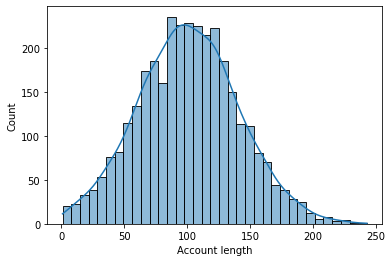

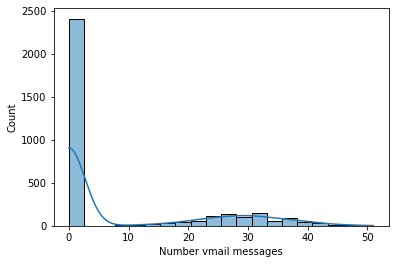

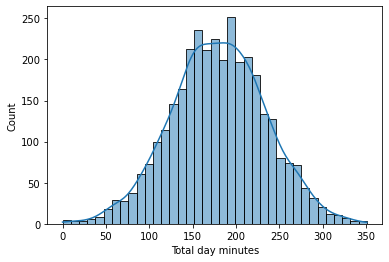

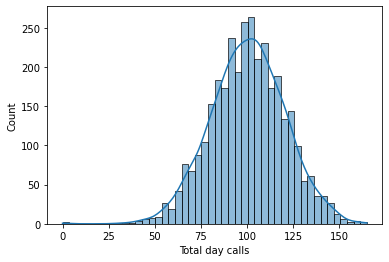

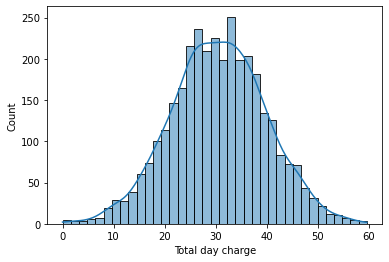

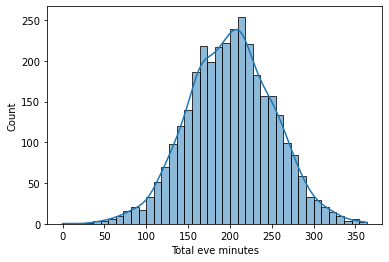

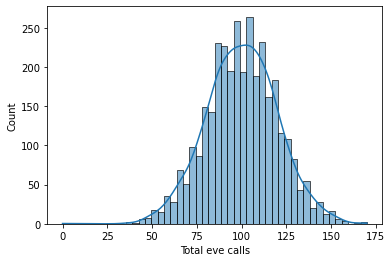

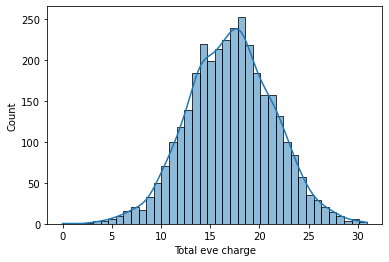

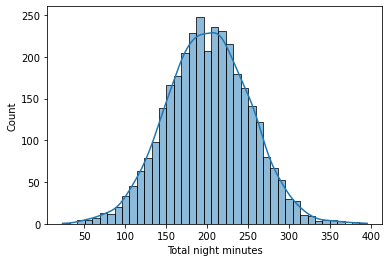

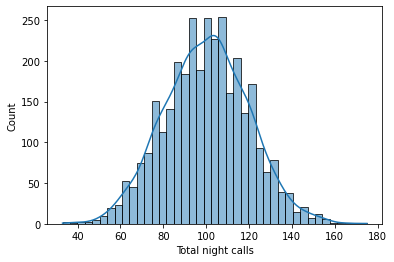

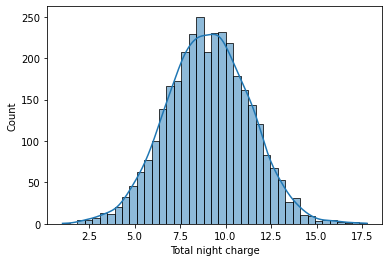

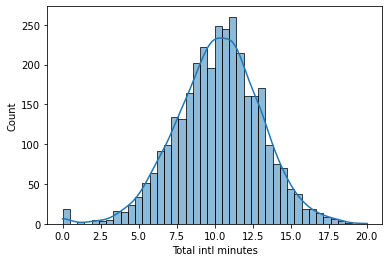

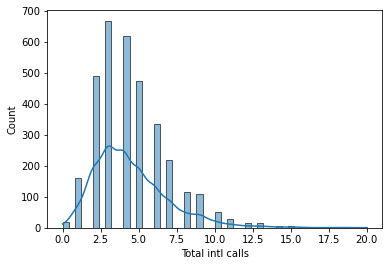

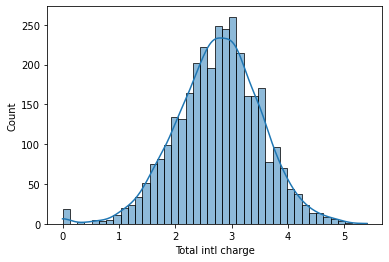

In [7]:
eda.hist_plot()

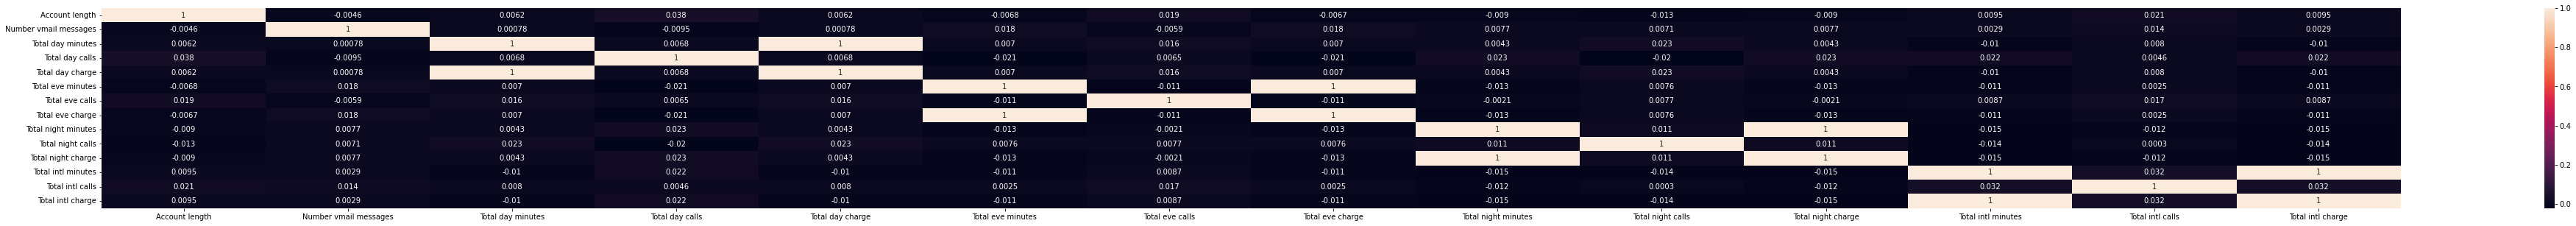

In [8]:
eda.correlation()

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


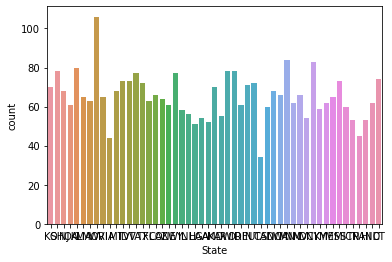

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


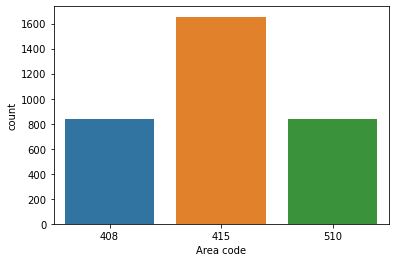

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


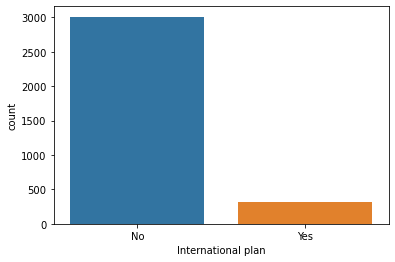

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


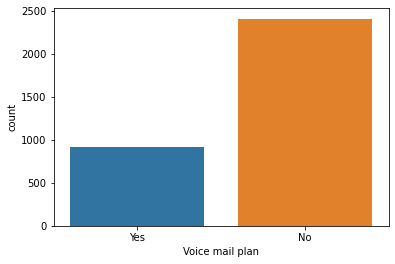

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


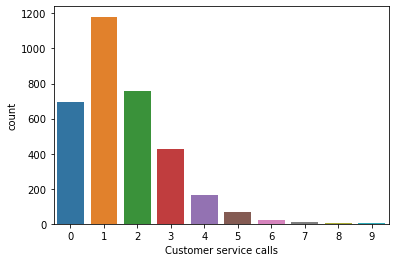

In [9]:
eda.count_plot()

## Drop unusfull features

> ***Total day minutes & Total eve minutes & Total intl minutes*** >> because both of them has high-correlations with other features (3 features) **Multicollinearity**
> ***Number vmail messages*** >> the most of samples has one-vale **autocorrelation**

In [10]:
dataFrame = dataFrame.drop(['Total day minutes','Total eve minutes', 'Total intl minutes','Number vmail messages'],axis=1)

## Handle non-numerc features

In [11]:
ind = dataFrame.dtypes[dataFrame.dtypes == object].index
[print(i , dataFrame[i].unique()) for i in ind] 

State ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'WV' 'RI' 'IA' 'MT' 'ID' 'VT' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'NE' 'WY' 'IL' 'NH' 'LA' 'GA' 'AK' 'MD' 'AR' 'WI'
 'OR' 'DE' 'IN' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'NY' 'KY'
 'ME' 'MS' 'MI' 'SC' 'TN' 'PA' 'HI' 'ND' 'CT']
International plan ['No' 'Yes']
Voice mail plan ['Yes' 'No']


[None, None, None]

In [12]:
# for binary features make dummy for them
dataFrame['International plan'] = dataFrame['International plan'].replace(['No','Yes'], [0,1])
dataFrame['Voice mail plan'] = dataFrame['Voice mail plan'].replace(['No','Yes'], [0,1])

ind = ind.drop(['Voice mail plan', 'International plan'])

# for nominal features make dummy for them [assume that all of them nominal]
for i in ind:
    pd.get_dummies(dataFrame[i], dtype=int, 
                                   columns= dataFrame[i].unique())
    dataFrame = dataFrame.drop([i],axis=1)

In [13]:
dataFrame['Churn'] = dataFrame['Churn'].replace(['No','Yes'], [0,1])

In [14]:
dataFrame.columns

Index(['Account length', 'Area code', 'International plan', 'Voice mail plan',
       'Total day calls', 'Total day charge', 'Total eve calls',
       'Total eve charge', 'Total night minutes', 'Total night calls',
       'Total night charge', 'Total intl calls', 'Total intl charge',
       'Customer service calls', 'Churn'],
      dtype='object')

## split dataFrame

In [15]:
#  into target and features 
x = dataFrame.drop(['Churn'],axis=1)
y = dataFrame['Churn']

In [16]:
# into train & test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=5, stratify=y)

# Build - Models

## KNN

In [ ]:
knn = KNeighborsClassifier()
params = { 'n_neighbors' : np.arange(1, 12), 'p' :  np.arange(1, 5) }
sCV = StratifiedKFold(10)

In [ ]:
model = GridSearchCV(estimator=knn,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newKNN = model.estimator

In [ ]:
newKNN.p= 1
newKNN.n_neighbors = 5

In [ ]:
newKNN.fit(x_train,y_train)

In [ ]:
y_pre_tr = newKNN.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newKNN.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## DT

In [ ]:
dt = DecisionTreeClassifier()
params = { 'criterion' : ['gini', 'entropy'], 'max_depth' :  np.arange(10, 30), 'min_samples_leaf':np.arange(1, 5)}
sCV = StratifiedKFold(10)

In [ ]:
model = GridSearchCV(estimator=dt,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newDT = model.best_estimator_

In [ ]:
newDT.min_samples_leaf , newDT.max_depth = 3, 10 

In [ ]:
newDT.fit(x_train,y_train)

In [ ]:
y_pre_tr = newDT.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## Logestic Regression

In [ ]:
lg = LogisticRegression()
params = { 'C' : np.arange(1, 10), 'penalty' :  ['l1','l2']}
sCV = StratifiedKFold(10)

In [ ]:
model = GridSearchCV(estimator=lg,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newLR = model.estimator

In [ ]:
newLR.C = 2

In [ ]:
newLR.fit(x_train,y_train)

In [ ]:
y_pre_tr = newLR.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newLR.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## BernoulliNB

In [ ]:
be = BernoulliNB()
params = { 'alpha' : np.arange(0, 1,0.2), 'binarize' :  np.arange(0, 1,0.2)}
sCV = StratifiedKFold(10)

In [ ]:
model = GridSearchCV(estimator=be,cv=sCV,n_jobs=10,scoring='roc_auc', param_grid=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newNB = model.estimator

In [ ]:
newNB.binarize, newNB.alpha = 0.4,0.0

In [ ]:
newNB.fit(x_train,y_train)

In [ ]:
y_pre_tr = newNB.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newNB.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## AdaBoost

In [ ]:
ad = AdaBoostClassifier()
params = { 'n_estimators' : np.arange(50, 200,10), 'learning_rate' :  [0.001, 0.01, 0.1, 1.0]}
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=ad,cv=sCV,n_iter=10,scoring='roc_auc', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newAD = model.estimator

In [ ]:
newAD.n_estimators, newAD.learning_rate = 90, 0.1

In [ ]:
newAD.fit(x_train,y_train)

In [ ]:
y_pre_tr = newAD.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

In [ ]:
lg = LogisticRegression()
params = { 'C' : np.arange(1, 10), 'penalty' :  ['l1','l2']}
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=lg,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newLR = model.estimator

In [ ]:
newLR.C = 6

In [ ]:
newLR.fit(x_train,y_train)

In [ ]:
y_pre_tr = newDT.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## GradientBoost

In [17]:
gb = GradientBoostingClassifier()

params = { 'learning_rate' : [0.001,0.01,0.1,1.0], 'n_estimators' :  [100,200,300],
           'min_samples_split' : np.arange(2,7), 'min_samples_leaf' : np.arange(1,32),
           'max_depth' : np.arange(3,12)}

sCV = StratifiedKFold(10)

In [18]:
model = RandomizedSearchCV(estimator=gb,cv=sCV,n_iter=10,scoring='roc_auc', param_distributions=params)

In [19]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          1.0],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
                                        'min_samples_split': array([2, 3, 4, 5, 6]),
                                        'n_estimators': [100, 200, 300]},
                   scoring='roc_auc')

In [20]:
model.best_score_

0.906975716371519

In [21]:
model.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 12,
 'max_depth': 11,
 'learning_rate': 1.0}

In [22]:
newGB = model.estimator

In [23]:
newGB.n_estimators ,newGB.min_samples_split ,newGB.min_samples_leaf ,newGB.max_depth ,newGB.learning_rate = 100,2,12,11,1

In [24]:
newGB.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=11, min_samples_leaf=12)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1995
        True       1.00      1.00      1.00       338

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333



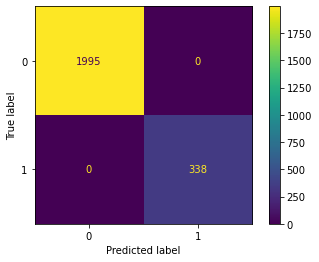

In [25]:
y_pre_tr = newGB.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

              precision    recall  f1-score   support

       False       0.95      0.98      0.97       855
        True       0.89      0.70      0.78       145

    accuracy                           0.94      1000
   macro avg       0.92      0.84      0.88      1000
weighted avg       0.94      0.94      0.94      1000



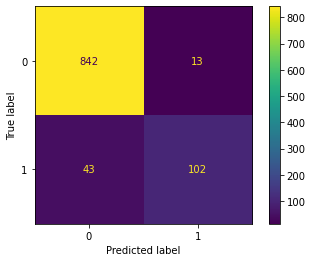

In [27]:
y_pre_te = newGB.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## XGradientBoost 

In [28]:
xg = xgb.XGBClassifier(objective='binary:logistic', subsample=0.9, colsample_bytree=0.5)

lis = np.arange(0.1,1, 0.1).tolist()
lis.extend(np.arange(1,11).tolist())
lis.extend(np.arange(80,1001).tolist())

params = { 'learning_rate' : [0.001,0.01,0.,1.0], 'n_estimators' :  [100,200,300],
           'scale_pos_weight' : np.arange(2,7),
           'max_depth' : np.arange(3,12), 'gamma' : lis,
           'reg_lambda' : lis}
sCV = StratifiedKFold(10)

In [29]:
model = RandomizedSearchCV(estimator=xg, cv=sCV,scoring='roc_auc', param_distributions=params)

In [30]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.5,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           int...
                                                  1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  80, 81, 82, 83, 84, 85, 86,
                      

In [31]:
model.best_score_

0.7766633692078934

In [32]:
model.best_params_

{'scale_pos_weight': 3,
 'reg_lambda': 168,
 'n_estimators': 200,
 'max_depth': 10,
 'learning_rate': 0.01,
 'gamma': 175}

In [33]:
newXG = model.estimator

In [34]:
newXG.scale_pos_weight ,newXG.reg_lambda ,newXG.n_estimators ,newXG.max_depth ,newXG.learning_rate ,newXG.gamma = \
3,168,200,10,0.01,175

In [35]:
newXG.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=175, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=168, ...)

              precision    recall  f1-score   support

       False       0.86      1.00      0.92      1995
        True       0.00      0.00      0.00       338

    accuracy                           0.86      2333
   macro avg       0.43      0.50      0.46      2333
weighted avg       0.73      0.86      0.79      2333



C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


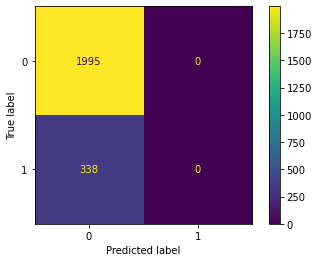

In [36]:
y_pre_tr = newXG.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.85      1.00      0.92       855
        True       0.00      0.00      0.00       145

    accuracy                           0.85      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.73      0.85      0.79      1000



C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ABO ELKHEIR\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


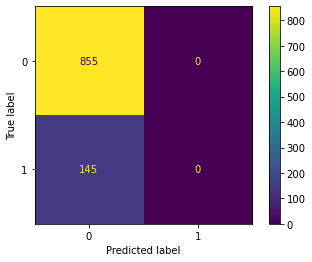

In [37]:
y_pre_te = newXG.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

## SVC

In [ ]:
svc = SVC()
params = { 'C' : np.arange(1, 12), 'degree' :  np.arange(1, 5), 'kernel': ['linear', 'rbf', 'sigmoid']}
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=svc,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newSVC = model.estimator

In [ ]:
newSVC.C=
newSVC.degree=
newSVC.kernal=

In [ ]:
newSVC.fit(x_train,y_train)

In [ ]:
y_pre_tr = newSVC.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newSVC.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

In [ ]:
## Train Model with Sts

In [ ]:
knn = KNeighborsClassifier()
params = { 'n_neighbors' : np.arange(1, 12), 'p' :  np.arange(1, 5) }
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=knn,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newKNN = model.estimator

In [ ]:
newKNN.p= 4
newKNN.n_neighbors = 8

In [ ]:
newKNN.fit(x_train,y_train)

In [ ]:
y_pre_tr = newKNN.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newKNN.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

In [ ]:
dt = DecisionTreeClassifier()
params = { 'criterion' : ['gini', 'entropy'], 'max_depth' :  np.arange(10, 30), 'min_samples_leaf':np.arange(1, 5)}
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=dt,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newDT = DecisionTreeClassifier(min_samples_leaf=4, max_depth=12)

In [ ]:
newDT.fit(x_train,y_train)

In [ ]:
y_pre_tr = newDT.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newDT.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))

In [ ]:
lg = LogisticRegression()
params = { 'C' : np.arange(1, 10), 'penalty' :  ['l1','l2']}
sCV = StratifiedKFold(10)

In [ ]:
model = RandomizedSearchCV(estimator=lg,cv=sCV,n_iter=10,scoring='accuracy', param_distributions=params)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
model.best_score_

In [ ]:
model.best_params_

In [ ]:
newLR = model.estimator

In [ ]:
newLR.C = 6

In [ ]:
newLR.fit(x_train,y_train)

In [ ]:
y_pre_tr = newLR.predict(x_train)
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pre_tr)).plot()
print(classification_report(y_train, y_pre_tr))

In [ ]:
y_pre_te = newLR.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pre_te)).plot()
print(classification_report(y_test, y_pre_te))